# Proyecto Final: Clasificación de Sentimientos

In [1]:
# Librerías principales
import pandas as pd
import numpy as np

from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
import torch
# Visualización
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Preprocesamiento de texto
import re
from collections import Counter
#Identificar palabras clave por sentimientos
from nltk.corpus import stopwords
import nltk

from nltk.stem import WordNetLemmatizer, SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

# Configuracion
from transformers import AutoTokenizer, AutoModel
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
#Dividir el data set
from sklearn.model_selection import train_test_split

#Importamos las librerias para los algoritmos
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from imblearn.over_sampling import RandomOverSampler
from tqdm import tqdm

# COLORES DE MATPLOT y tamaño de las gráficas
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

d:\Principal\Respaldo Diws 2020\Buap\Octavo Semestre\Mineria\proyecto final\codigos\env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [50]:
# Descargar stopwords si es necesario
nltk.download('stopwords')
stop_words = set(stopwords.words('spanish')) 
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Diws\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Diws\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
# Definir stopwords en español
stop_words = set(stopwords.words('spanish'))

# Inicializar lematizador y stemmer
lemmatizer = WordNetLemmatizer()
stemmer = SnowballStemmer("spanish")

<h1> Análisis Exploratorio de Datos (EDA) </h1>

In [51]:
# Cargar el dataset
dataset_path = "Textos_Dataset_Completo.csv"  # Cambia el path si es necesario
dataset = pd.read_csv(dataset_path, encoding="latin1")

In [52]:
# Mostrar información básica
print("Información del Dataset:")
print(dataset.info())

Información del Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 288 entries, 0 to 287
Data columns (total 20 columns):
 #   Column                                                                                                                                                                                                                      Non-Null Count  Dtype 
---  ------                                                                                                                                                                                                                      --------------  ----- 
 0   Marca temporal                                                                                                                                                                                                              288 non-null    object
 1   ID ònico                                                                                                                 

In [53]:
print("\nVista preliminar del Dataset:")
print(dataset.head())


Vista preliminar del Dataset:
       Marca temporal  ID ònico  Edad:    Gnero: Nivel socioeconmico:  \
0  4/23/2024 19:48:07  PFNKXS54     28  Masculino                 Medio   
1  4/23/2024 19:48:07  MKZUPRJI     21  Masculino                  Bajo   
2  4/23/2024 19:48:07  UJCL56SG     22  Masculino                 Medio   
3  4/23/2024 19:48:07  B2KUCT4P     20   Femenino                 Medio   
4  4/23/2024 19:48:07  GXLRPJ5F     22   Femenino                 Medio   

  Grado de estudios: Actualmente te encuentras:  \
0           Maestra                      Ambos   
1       Licenciatura                      Ambos   
2       Licenciatura                      Ambos   
3       Licenciatura                 Estudiando   
4       Licenciatura                 Estudiando   

     Si actualmente trabajas. ÀEn qu rea trabajas? Estado de origen:  \
0  Sector de la educacin - Maestros, educadores,...          Veracruz   
1  Comercio y ventas - Vendedores, gerentes de ti...          V

In [7]:
# Verificar valores nulos
print("\nValores nulos por columna:")
print(dataset.isnull().sum())


Valores nulos por columna:
Marca temporal                                                                                                                                                                                                                0
ID ònico                                                                                                                                                                                                                      1
Edad:                                                                                                                                                                                                                         0
Gnero:                                                                                                                                                                                                                       0
Nivel socioeconmico:                                                       

In [54]:
#Eliminar valores nulos
dataset.dropna(inplace=True)

In [55]:
#Verificar valores nulos
print("\nValores nulos por columna:")
print(dataset.isnull().sum())


Valores nulos por columna:
Marca temporal                                                                                                                                                                                                                0
ID ònico                                                                                                                                                                                                                      0
Edad:                                                                                                                                                                                                                         0
Gnero:                                                                                                                                                                                                                       0
Nivel socioeconmico:                                                       

In [56]:
# Respuestas por pregunta
preguntas = [col for col in dataset.columns if col.startswith('1.') or col.startswith('2.') or col.startswith('3.')or col.startswith('4.')or col.startswith('5.')
             or col.startswith('6.') or col.startswith('7.') or col.startswith('8.') or col.startswith('9.') or col.startswith('10.')]
print("Cantidad de respuestas por pregunta:")
for pregunta in preguntas:
    print(f"{pregunta}: {dataset[pregunta].notnull().sum()} respuestas")

Cantidad de respuestas por pregunta:
1. Describa, Àen qu situaciones ltimamente ha sentido alegra?: 287 respuestas
2. Especifique, Àen qu situaciones ltimamente ha sentido ganas de llorar?: 287 respuestas
3. En las ltimas dos semanas, Àen qu momentos se ha sentido cansado?: 287 respuestas
4. ÀEn qu situaciones de su da a da, puede identificar que se ha sentido preocupado?: 287 respuestas
5. Cuando la preocupacin se hace presente en su vida, Àcules son las sensaciones corporales que experimenta?: 287 respuestas
6. Si su escritor favorito le pidiera que le ayude a buscar el significado de la felicidad, Àcul sera la idea que usted escribira?: 287 respuestas
7. Cuando tiene una eleccin importante que hacer, mencione Àcules seran los pasos que seguira para llegar a tomar una decisin?: 287 respuestas
8. Cuando sucede algo inesperado en su vida, por ejemplo: llegar tarde al trabajo, el automvil se descompuso, se qued sin batera el celular, olvidar las llaves, etc., desc

In [57]:
#Categorias de las preguntas
categorias = {
    "Alegría": ["1.", "6."],
    "Tristeza": ["2."],
    "Estrés": ["3.", "9."],
    "Inquietud/Preocupación": ["4.", "5."],
    "Miedo": ["7.", "10."],
    "Enojo": ["8."]
}

In [58]:
# Frecuencia de categorías de sentimiento
frecuencias = {}
for categoria, preguntas_cat in categorias.items():
    # Filtrar columnas que coincidan con los prefijos dados
    columnas = [col for col in dataset.columns if any(col.startswith(p) for p in preguntas_cat)]
    # Contar respuestas no nulas en estas columnas
    total_respuestas = dataset[columnas].notnull().sum().sum()
    frecuencias[categoria] = total_respuestas

In [59]:
print("\nFrecuencia de respuestas por categoría de sentimiento:")
print(frecuencias)


Frecuencia de respuestas por categoría de sentimiento:
{'Alegría': np.int64(574), 'Tristeza': np.int64(287), 'Estrés': np.int64(574), 'Inquietud/Preocupación': np.int64(574), 'Miedo': np.int64(574), 'Enojo': np.int64(287)}


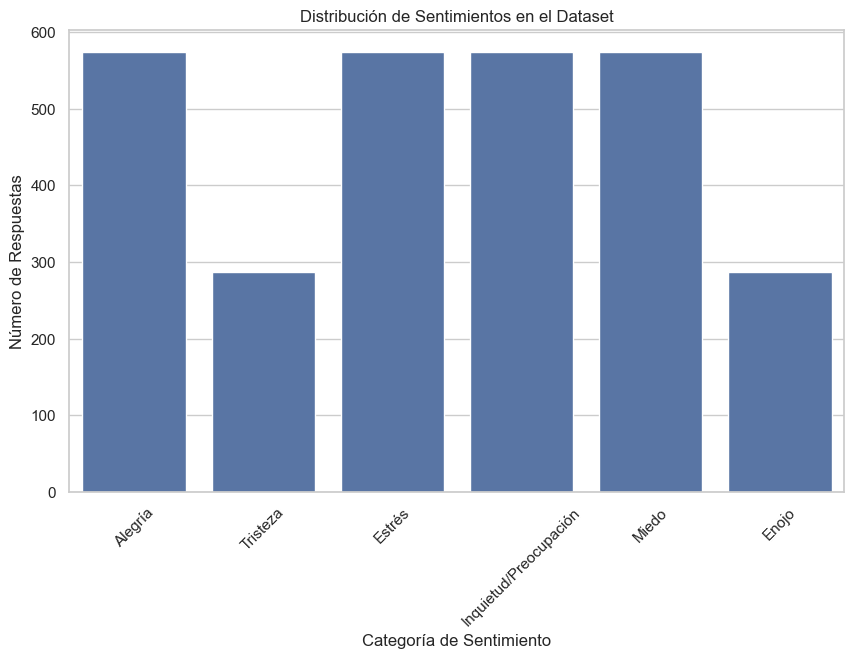

In [60]:
# Visualización de frecuencias corregidas
sns.barplot(x=list(frecuencias.keys()), y=list(frecuencias.values()))
plt.title("Distribución de Sentimientos en el Dataset")
plt.xlabel("Categoría de Sentimiento")
plt.ylabel("Número de Respuestas")
plt.xticks(rotation=45)
plt.show()

In [61]:
for categoria, frecuencia in frecuencias.items():
    print(f"{categoria}: {frecuencia}")

Alegría: 574
Tristeza: 287
Estrés: 574
Inquietud/Preocupación: 574
Miedo: 574
Enojo: 287


In [62]:
def generar_nube_palabras(data, columnas, titulo):
    # Concatenar respuestas en una sola cadena, asegurando que todo sea texto
    texto = " ".join(data[columnas].fillna("").astype(str).sum(axis=1))
    
    # Crear la nube de palabras
    nube = WordCloud(width=800, height=400, background_color="white", colormap="viridis").generate(texto)
    
    # Mostrar la nube de palabras
    plt.figure(figsize=(10, 6))
    plt.imshow(nube, interpolation="bilinear")
    plt.title(titulo, fontsize=16)
    plt.axis("off")
    plt.show()

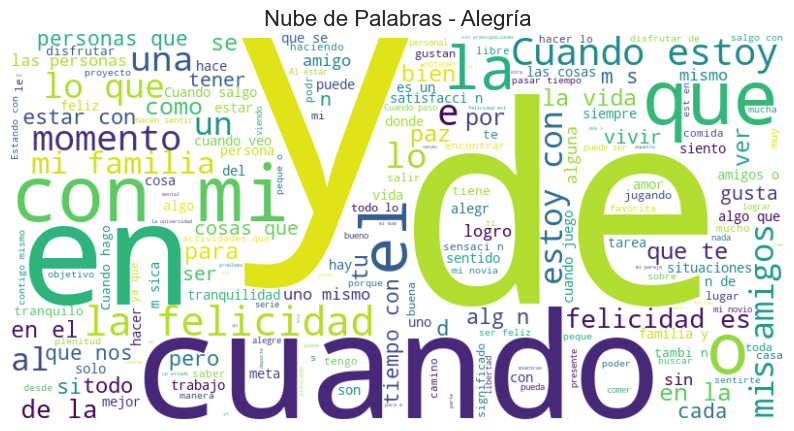

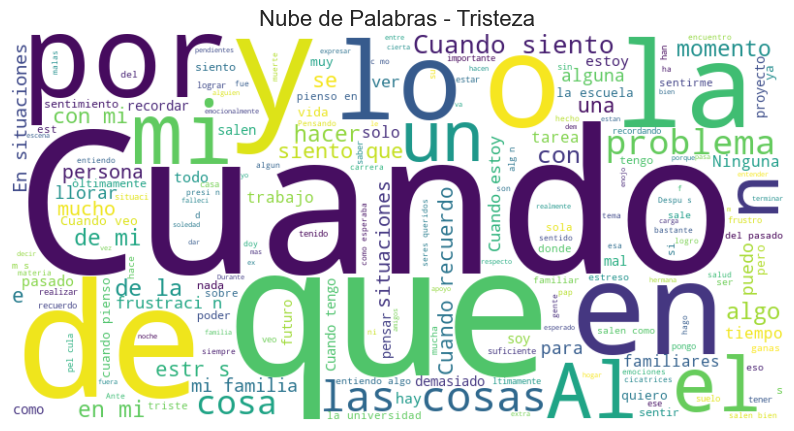

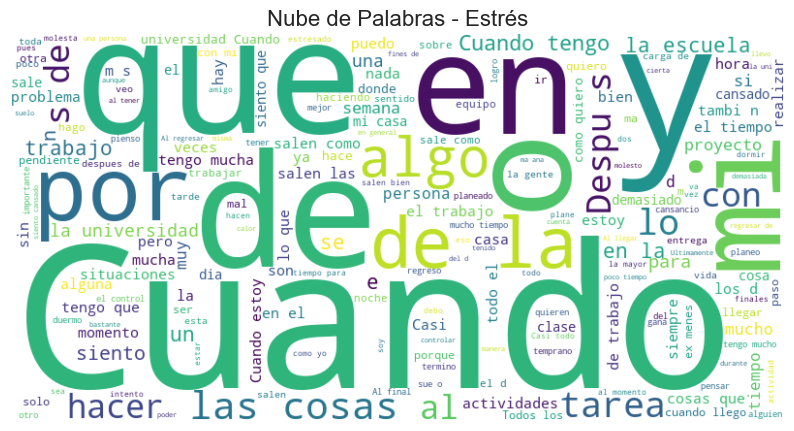

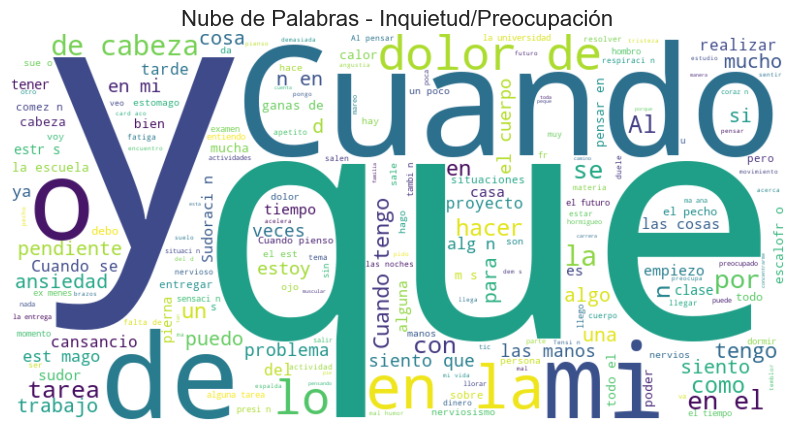

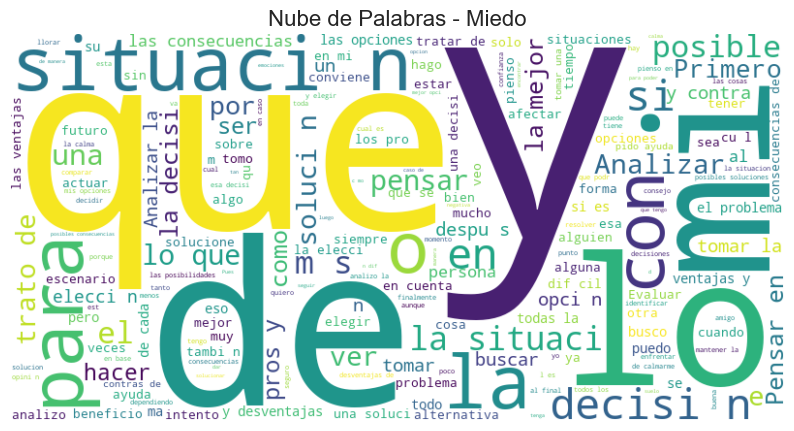

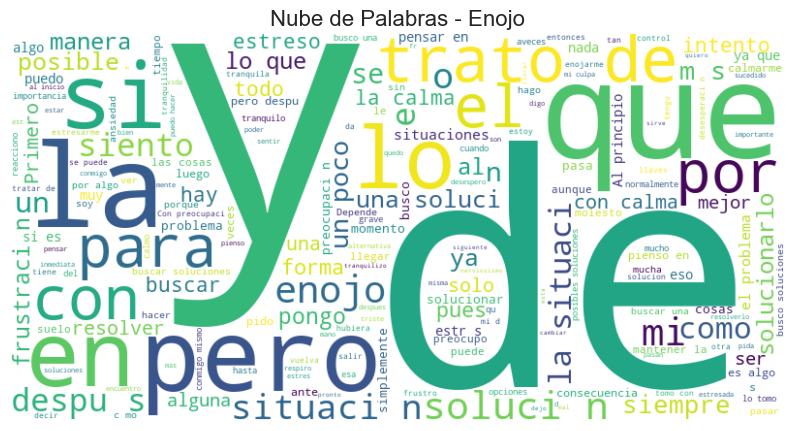

In [63]:
# Generar nube de palabras para cada sentimiento
for sentimiento, preguntas_cat in categorias.items():
    columnas = [col for col in dataset.columns if any(col.startswith(p) for p in preguntas_cat)]
    generar_nube_palabras(dataset, columnas, f"Nube de Palabras - {sentimiento}")

In [64]:
def palabras_frecuentes(data, columnas, titulo, top_n=10):
    """
    Identificar las palabras más frecuentes en un conjunto de textos.
    """
    # Concatenar todas las respuestas en una sola cadena
    texto = " ".join(data[columnas].fillna("").astype(str).sum(axis=1))
    
    # Preprocesar el texto: convertir a minúsculas y eliminar caracteres especiales
    texto_limpio = re.sub(r"[^a-zA-ZáéíóúñÑ\s]", "", texto.lower())
    
    # Tokenizar el texto
    palabras = texto_limpio.split()
    
    # Filtrar palabras vacías (stopwords)
    palabras = [palabra for palabra in palabras if palabra not in stop_words]
    
    # Contar la frecuencia de cada palabra
    conteo = Counter(palabras)
    
    # Obtener las palabras más comunes
    palabras_comunes = conteo.most_common(top_n)
    
    # Mostrar resultados
    print(f"Palabras más frecuentes para {titulo}:")
    for palabra, frecuencia in palabras_comunes:
        print(f"{palabra}: {frecuencia}")
    
    # Visualizar con una gráfica de barras
    palabras, frecuencias = zip(*palabras_comunes)
    plt.bar(palabras, frecuencias)
    plt.title(f"Palabras más frecuentes - {titulo}")
    plt.xlabel("Palabras")
    plt.ylabel("Frecuencia")
    plt.xticks(rotation=45)
    plt.show()

Palabras más frecuentes para Alegría:
felicidad: 121
amigos: 85
familia: 54
vida: 54
cosas: 53
mismo: 47
personas: 46
tiempo: 42
bien: 42
momentos: 37


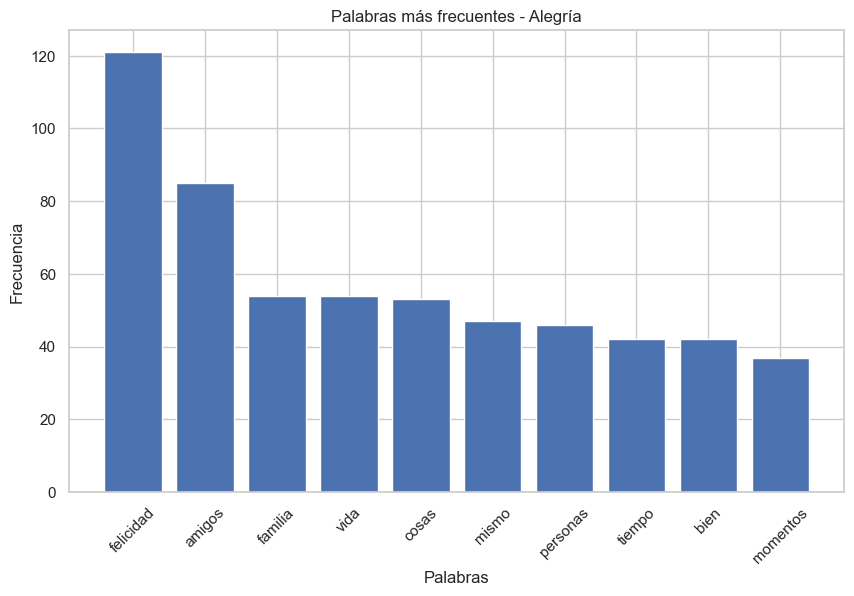

Palabras más frecuentes para Tristeza:
siento: 49
cosas: 48
situaciones: 31
hacer: 20
salen: 20
recuerdo: 20
problemas: 19
estrs: 17
familia: 17
pasado: 17


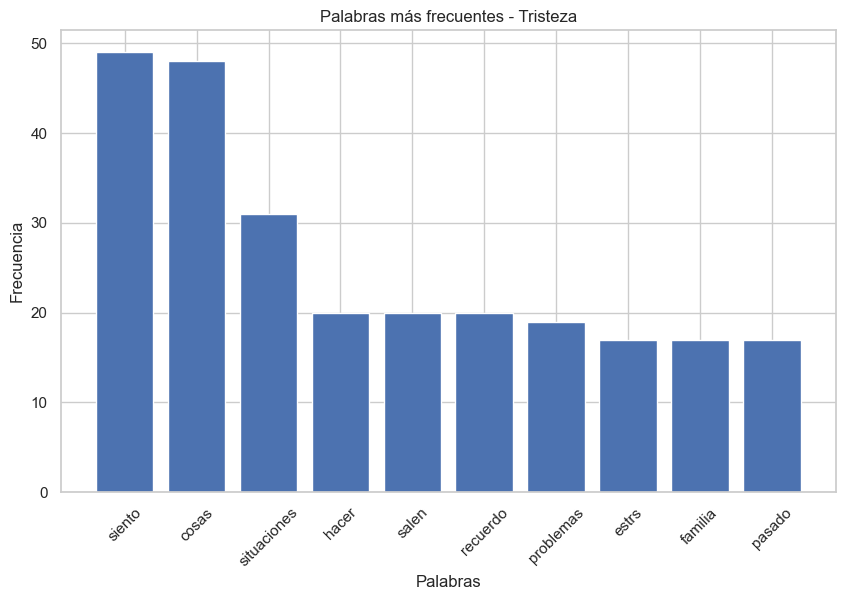

Palabras más frecuentes para Estrés:
cosas: 98
trabajo: 61
tiempo: 58
siento: 55
despus: 51
hacer: 48
salen: 47
escuela: 44
tareas: 37
casa: 34


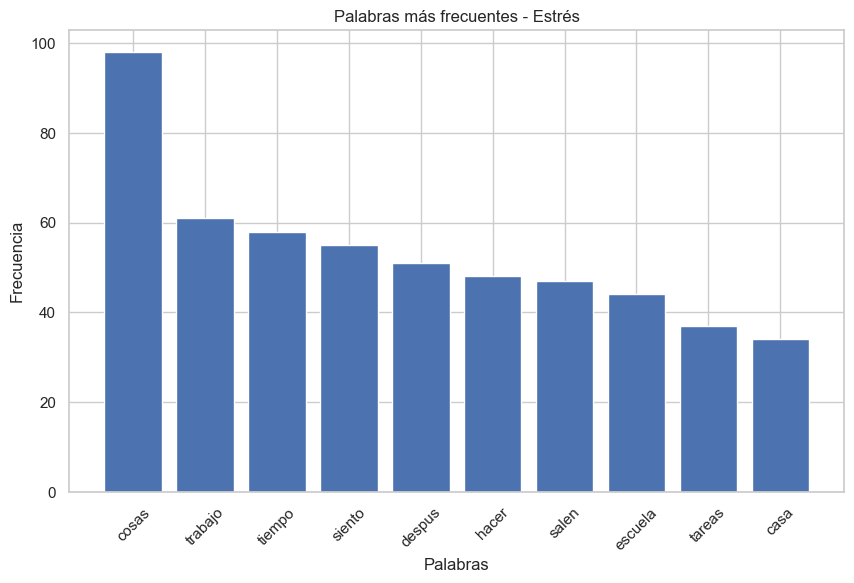

Palabras más frecuentes para Inquietud/Preocupación:
cabeza: 72
dolor: 63
siento: 41
hacer: 40
cosas: 36
tareas: 27
manos: 27
cuerpo: 26
da: 24
pensar: 24


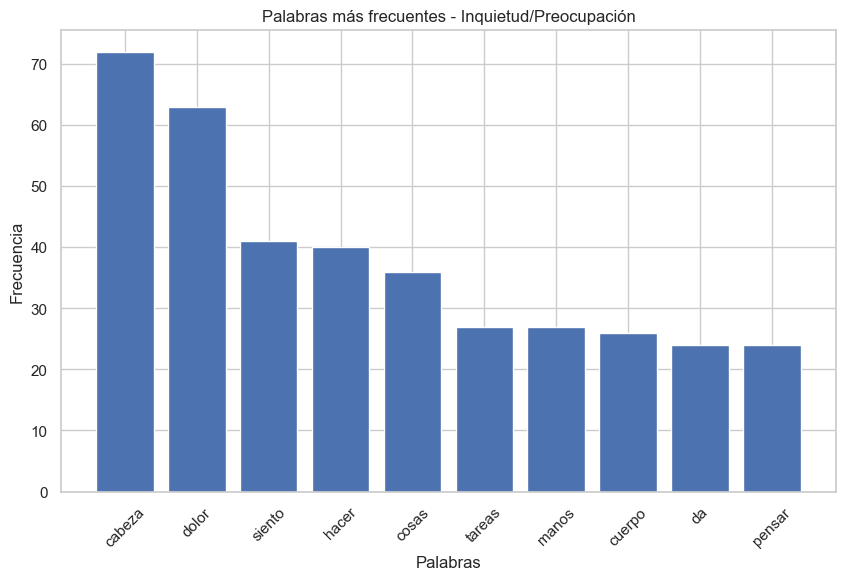

Palabras más frecuentes para Miedo:
situacin: 123
si: 118
pensar: 109
analizar: 94
decisin: 84
tomar: 84
ms: 83
mejor: 76
consecuencias: 72
posibles: 66


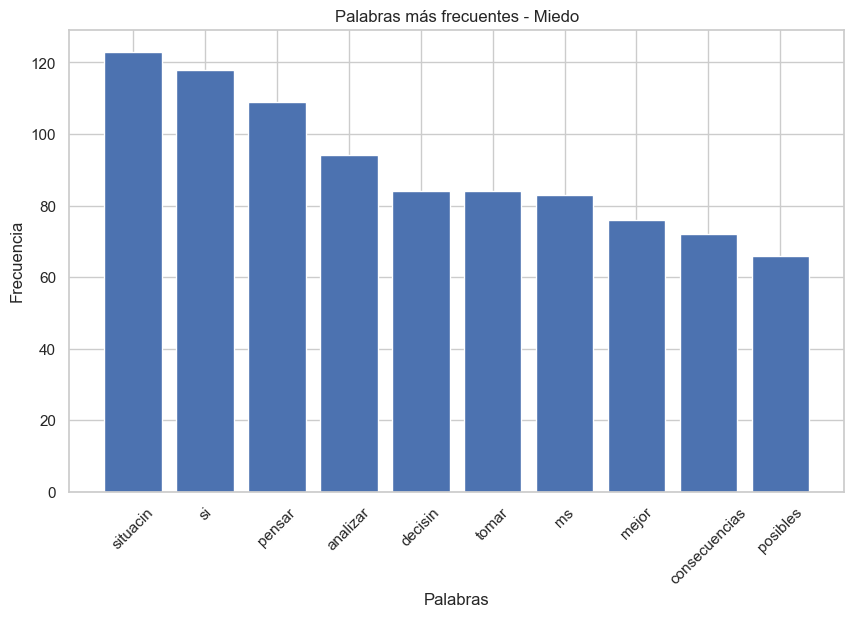

Palabras más frecuentes para Enojo:
si: 70
trato: 50
solucin: 37
enojo: 36
situacin: 32
buscar: 30
calma: 30
despus: 28
siento: 28
soluciones: 28


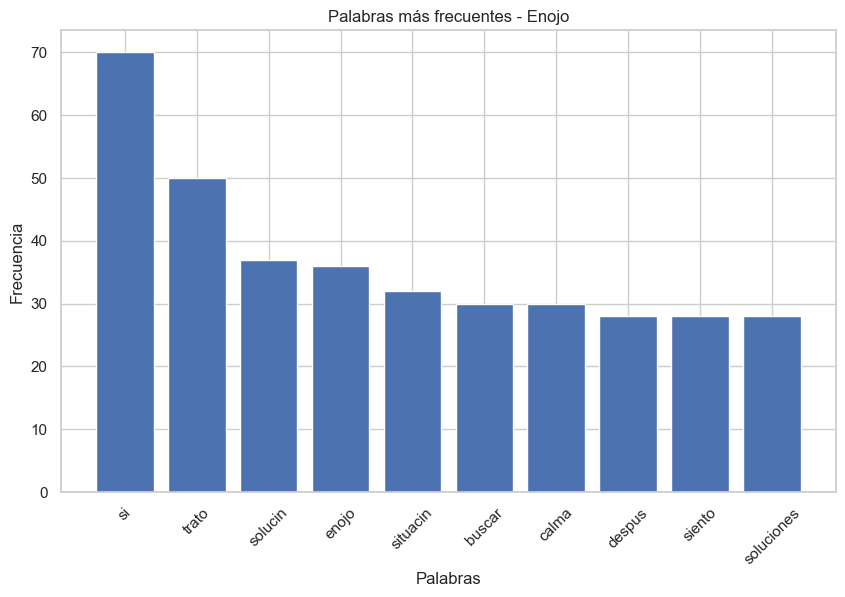

In [65]:
# Identificar palabras clave para cada sentimiento
for sentimiento, preguntas_cat in categorias.items():
    columnas = [col for col in dataset.columns if any(col.startswith(p) for p in preguntas_cat)]
    palabras_frecuentes(dataset, columnas, sentimiento, top_n=10)

<h1> Preprocesamiento de Texto </h1>

In [66]:
print(dataset.columns)

Index(['Marca temporal', 'ID ònico', 'Edad:', 'Gnero:',
       'Nivel socioeconmico:', 'Grado de estudios:',
       'Actualmente te encuentras:',
       'Si actualmente trabajas. ÀEn qu rea trabajas?', 'Estado de origen:',
       'Municipio de origen:',
       '1. Describa, Àen qu situaciones ltimamente ha sentido alegra?',
       '2. Especifique, Àen qu situaciones ltimamente ha sentido ganas de llorar?',
       '3. En las ltimas dos semanas, Àen qu momentos se ha sentido cansado?',
       '4. ÀEn qu situaciones de su da a da, puede identificar que se ha sentido preocupado?',
       '5. Cuando la preocupacin se hace presente en su vida, Àcules son las sensaciones corporales que experimenta?',
       '6. Si su escritor favorito le pidiera que le ayude a buscar el significado de la felicidad, Àcul sera la idea que usted escribira?',
       '7. Cuando tiene una eleccin importante que hacer, mencione Àcules seran los pasos que seguira para llegar a tomar una decisi

In [67]:
def limpiar_texto(texto):
    # Convertir a minúsculas
    texto = texto.lower()
    # Eliminar caracteres especiales y números
    texto = re.sub(r"[^a-záéíóúñ\s]", "", texto)
    # Eliminar números
    texto = re.sub(r"\d+", "", texto)
    return texto

In [68]:
def procesar_texto(texto, stop_words, lematizar=True):
    texto_limpio = limpiar_texto(texto)
    palabras = texto_limpio.split()  # Tokenización
    palabras = [palabra for palabra in palabras if palabra not in stop_words]  # Eliminar stopwords
    
    # Lematización o stemming
    if lematizar:
        palabras = [lemmatizer.lemmatize(palabra) for palabra in palabras]
    else:
        palabras = [stemmer.stem(palabra) for palabra in palabras]
    return " ".join(palabras)  # Reunir palabras en un solo string

In [23]:
# Definir la función de procesamiento general
def procesar_todas_las_columnas(dataset, stop_words):
    """
    Aplica procesamiento a todas las columnas del dataset.
    - Limpia texto para columnas de texto.
    - Convierte valores numéricos o categóricos en cadenas para consistencia.
    """
    for col in dataset.columns:
        dataset[col] = dataset[col].fillna("").apply(
            lambda x: procesar_texto(str(x), stop_words) if isinstance(x, str) else str(x)
        )
    return dataset

# Aplicar la función al dataset completo
dataset = procesar_todas_las_columnas(dataset, stop_words)

# Verificar los resultados
print(dataset.head())

  Marca temporal  ID ònico Edad:    Gnero: Nivel socioeconmico:  \
0                   pfnkxs    28  masculino                 medio   
1                 mkzuprji    21  masculino                  bajo   
2                   ujclsg    22  masculino                 medio   
3                   bkuctp    20   femenino                 medio   
4                  gxlrpjf    22   femenino                 medio   

  Grado de estudios: Actualmente te encuentras:  \
0            maestra                       ambo   
1       licenciatura                       ambo   
2       licenciatura                       ambo   
3       licenciatura                 estudiando   
4       licenciatura                 estudiando   

     Si actualmente trabajas. ÀEn qu rea trabajas? Estado de origen:  \
0  sector educacin maestro educadores administrad...          veracruz   
1  comercio ventas vendedores gerentes tienda rep...          veracruz   
2  sector administrativo oficina incluye role asi...    

In [69]:
dataset = procesar_todas_las_columnas(dataset, stop_words)

In [70]:
print("\nVista preliminar del Dataset:")
dataset.head()


Vista preliminar del Dataset:


,Marca temporal,ID ònico,Edad:,Gnero:,Nivel socioeconmico:,Grado de estudios:,Actualmente te encuentras:,Si actualmente trabajas. ÀEn qu rea trabajas?,Estado de origen:,Municipio de origen:,"1. Describa, Àen qu situaciones ltimamente ha sentido alegra?","2. Especifique, Àen qu situaciones ltimamente ha sentido ganas de llorar?","3. En las ltimas dos semanas, Àen qu momentos se ha sentido cansado?","4. ÀEn qu situaciones de su da a da, puede identificar que se ha sentido preocupado?","5. Cuando la preocupacin se hace presente en su vida, Àcules son las sensaciones corporales que experimenta?","6. Si su escritor favorito le pidiera que le ayude a buscar el significado de la felicidad, Àcul sera la idea que usted escribira?","7. Cuando tiene una eleccin importante que hacer, mencione Àcules seran los pasos que seguira para llegar a tomar una decisin?","8. Cuando sucede algo inesperado en su vida, por ejemplo: llegar tarde al trabajo, el automvil se descompuso, se qued sin batera el celular, olvidar las llaves, etc., describa Àcmo reacciona ante estas situaciones?",9. Describa ÀEn qu situaciones de su vida considera que se siente estresado o molesto?,"10. Por favor, describa brevemente Àqu hace cuando tiene que enfrentar una situacin difcil?"
0,,pfnkxs,28,masculino,medio,maestra,ambo,sector educacin maestro educadores administrad...,veracruz,coscomatepec,dando clases puedo salir divertirme amigo si v...,frustrado poder hacer trabajo siento dando anc...,da facultad tantas clases debo darl noche lleg...,trabajos pendientes entregar pasa duda genus m...,estrs siento agotado siento desanimado siento ...,ser humano pleno tranquilo querido persona sie...,analizar bien cul contexto eleccin pensar cule...,desespero suelo enojarme angustiarme cmo resol...,siento estresado pongo trabajar siento avanzo ...,enfrento situacin difcil trato analizar contex...
1,,mkzuprji,21,masculino,bajo,licenciatura,ambo,comercio ventas vendedores gerentes tienda rep...,veracruz,acultzingo,sale bien escuela trabajo,salen cosas,mm hago demasiadas actividades,sale,haces ataques antiedad dolor estmago cabeza,paz alegra,pensar consecuencias m buenas,preocupacin,salen cosas,pensar cmo resolverla
2,,ujclsg,22,masculino,medio,licenciatura,ambo,sector administrativo oficina incluye role asi...,tlaxcala,zacatelco,ver recuerdos pensar escenarios imaginarios,pensar cosas pasen planear cosas sucedan ver r...,preguntan cosas escuela pienso futuro simpleme...,tiempo vivo ansioso,sudor dolor espalda hombros sed hiperactividad,felicidad describira acorde conceto libertad c...,imaginar escenarios posibles ver puede ser mej...,estreso inicio despus rio problema digo meh su...,casa proyectos ayudan temas sociedad cosas con...,pondra llorar realmente intento descargarlo al...
3,,bkuctp,20,femenino,medio,licenciatura,estudiando,estudiante estn instituciones educativas,puebla,tecamachalco,paso tiempo amigo salir comer lugares,cosas salen quiero,saturo tareas,sale bien salga estare ahi preocupacion,fatiga tristeza,felicidad sientes paz,conviene ma razn lgica,primero reacciono impulso sensacin preocupacin...,semanas evaluaciones hacer tramites,trato tranquilizar si necesario pido ayuda hab...
4,,gxlrpjf,22,femenino,medio,licenciatura,estudiando,estudiante estn instituciones educativas,puebla,san matas tlalancaleca,hago recibo halagos hago ejercicio escucho pod...,enojo hermanas enojo novio,veces salgo prcticas hace calor,atiendo tareas debo hacer hago mal,nervios angustia estrs,felicidad pequeas cosas hacemos da da ayudan c...,pensar si buena eleccin futuro consultarlo fam...,estreso suelo empezar decir si salido si lleva...,sale planeo estudio veo reflejado nota ponen c...,tiendo pensar final aunque est segura hago enf...


<h1>Categorias y frecuencia</h1>

In [71]:
# Crear un diccionario para almacenar las respuestas por categoría
respuestas_por_categoria = {}

for categoria, preguntas_cat in categorias.items():
    # Filtrar columnas asociadas a la categoría
    columnas = [col for col in dataset.columns if any(col.startswith(p) for p in preguntas_cat)]
    # Combinar todas las respuestas de estas columnas
    respuestas_por_categoria[categoria] = dataset[columnas].fillna("").apply(lambda x: " ".join(x), axis=1)

# Convertir el diccionario a un DataFrame para inspección (opcional)
respuestas_df = pd.DataFrame(respuestas_por_categoria)

In [72]:
# Verificar las primeras filas del DataFrame
print(respuestas_df.head())

                                             Alegría  \
0  dando clases puedo salir divertirme amigo si v...   
1               sale bien escuela trabajo paz alegra   
2  ver recuerdos pensar escenarios imaginarios fe...   
3  paso tiempo amigo salir comer lugares felicida...   
4  hago recibo halagos hago ejercicio escucho pod...   

                                            Tristeza  \
0  frustrado poder hacer trabajo siento dando anc...   
1                                        salen cosas   
2  pensar cosas pasen planear cosas sucedan ver r...   
3                                 cosas salen quiero   
4                         enojo hermanas enojo novio   

                                              Estrés  \
0  da facultad tantas clases debo darl noche lleg...   
1         mm hago demasiadas actividades salen cosas   
2  preguntan cosas escuela pienso futuro simpleme...   
3  saturo tareas semanas evaluaciones hacer tramites   
4  veces salgo prcticas hace calor sale planeo

In [73]:
# Combinar todos los textos del dataset en una lista para la vectorización
textos = dataset.apply(lambda row: " ".join(row.astype(str)), axis=1)

# Configurar el vectorizador TF-IDF
vectorizer = TfidfVectorizer(max_features=500)  # Limitar a 500 características principales
tfidf_matrix = vectorizer.fit_transform(textos)

# Convertir a DataFrame para inspección
import pandas as pd
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

# Verificar el resultado
print(tfidf_df.head())

    18   19       20        21        22   23   24  accin  acciones  acerca  \
0  0.0  0.0  0.00000  0.000000  0.000000  0.0  0.0    0.0       0.0     0.0   
1  0.0  0.0  0.00000  0.137093  0.000000  0.0  0.0    0.0       0.0     0.0   
2  0.0  0.0  0.00000  0.000000  0.085122  0.0  0.0    0.0       0.0     0.0   
3  0.0  0.0  0.13435  0.000000  0.000000  0.0  0.0    0.0       0.0     0.0   
4  0.0  0.0  0.00000  0.000000  0.094112  0.0  0.0    0.0       0.0     0.0   

   ...       ver  veracruz  verdad  vez  vida  videojuegos  viendo  vista  \
0  ...  0.000000  0.084817     0.0  0.0   0.0          0.0     0.0    0.0   
1  ...  0.000000  0.173354     0.0  0.0   0.0          0.0     0.0    0.0   
2  ...  0.208703  0.000000     0.0  0.0   0.0          0.0     0.0    0.0   
3  ...  0.000000  0.000000     0.0  0.0   0.0          0.0     0.0    0.0   
4  ...  0.076915  0.000000     0.0  0.0   0.0          0.0     0.0    0.0   

   vivir  voy  
0    0.0  0.0  
1    0.0  0.0  
2    0.0  0.0 

In [29]:
# Inspeccionar las palabras más relevantes en el primer documento
palabras_importantes = tfidf_df.iloc[0].sort_values(ascending=False).head(10)
print(palabras_importantes)

siento       0.369315
cul          0.287283
estresado    0.201744
persona      0.200659
analizar     0.172222
decisin      0.168435
ser          0.164832
clases       0.163972
eleccin      0.160576
gusta        0.158961
Name: 0, dtype: float64


In [74]:
print(f"Total de características seleccionadas: {tfidf_df.shape[1]}")

Total de características seleccionadas: 500


In [75]:
print(tfidf_matrix.shape)
print(tfidf_matrix.nnz)  # Número de elementos no nulos

(287, 500)
14292


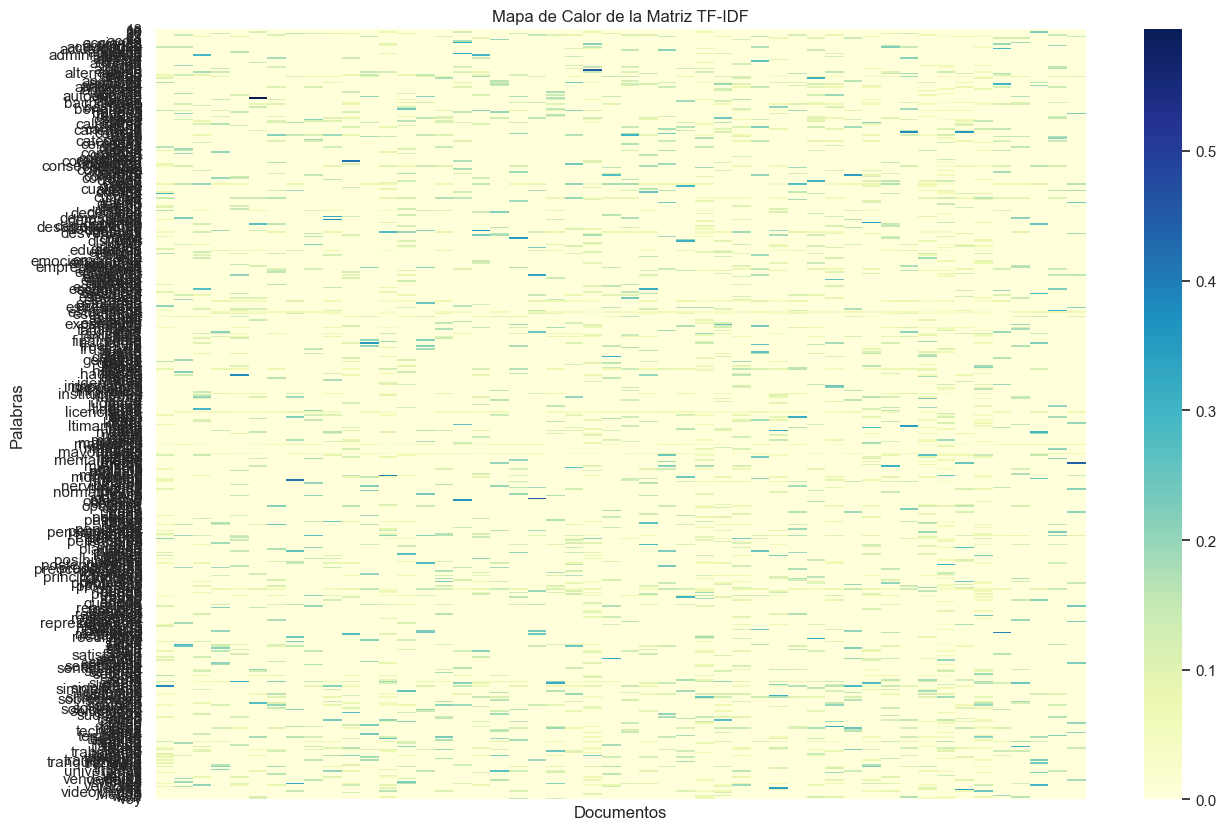

In [76]:
# Crear un mapa de calor para una muestra (por ejemplo, las primeras 50 palabras)
plt.figure(figsize=(15, 10))
sns.heatmap(tfidf_df.iloc[:50, :].T, cmap="YlGnBu", cbar=True, xticklabels=False, yticklabels=vectorizer.get_feature_names_out())
plt.title("Mapa de Calor de la Matriz TF-IDF")
plt.xlabel("Documentos")
plt.ylabel("Palabras")
plt.show()

In [77]:
# Combinar todas las columnas relacionadas con las preguntas
dataset['Texto_Procesado'] = dataset[
    [col for col in dataset.columns if col.startswith(tuple(str(i) for i in range(1, 11)))]
].apply(lambda x: " ".join(x), axis=1)

# Vectorizar el texto procesado usando TF-IDF
vectorizer = TfidfVectorizer(max_features=500)  # Puedes ajustar el número máximo de características
tfidf_matrix = vectorizer.fit_transform(dataset['Texto_Procesado'])

# Convertir a DataFrame para inspección
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())
print(tfidf_df.head())

   accin  acciones  acerca  actividad  actividades  actuar   acuerdo  adems  \
0    0.0       0.0     0.0        0.0     0.143806     0.0  0.000000    0.0   
1    0.0       0.0     0.0        0.0     0.185790     0.0  0.000000    0.0   
2    0.0       0.0     0.0        0.0     0.000000     0.0  0.000000    0.0   
3    0.0       0.0     0.0        0.0     0.000000     0.0  0.000000    0.0   
4    0.0       0.0     0.0        0.0     0.000000     0.0  0.156527    0.0   

   afecta  afectan  ...       veo       ver  verdad  vez  vida  videojuegos  \
0     0.0      0.0  ...  0.066259  0.000000     0.0  0.0   0.0          0.0   
1     0.0      0.0  ...  0.000000  0.000000     0.0  0.0   0.0          0.0   
2     0.0      0.0  ...  0.000000  0.222011     0.0  0.0   0.0          0.0   
3     0.0      0.0  ...  0.000000  0.000000     0.0  0.0   0.0          0.0   
4     0.0      0.0  ...  0.093725  0.075050     0.0  0.0   0.0          0.0   

   viendo  vista  vivir  voy  
0     0.0    0.0   

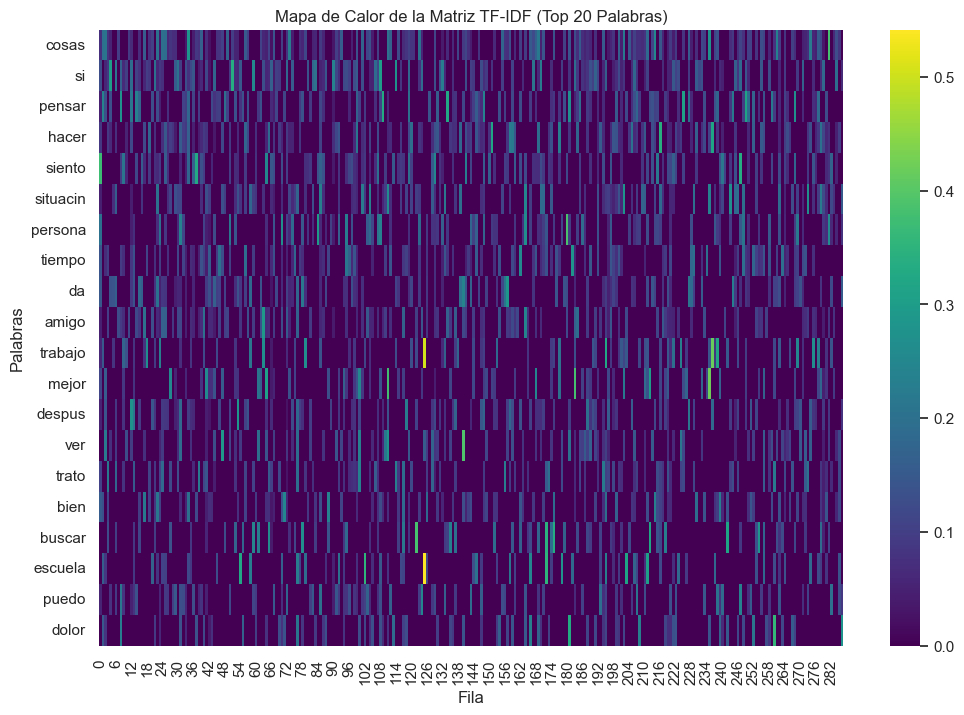

In [78]:
# Seleccionar las 20 palabras más frecuentes (mayores valores TF-IDF promedio)
top_words = tfidf_df.mean().sort_values(ascending=False).head(20).index

# Filtrar la matriz TF-IDF para estas palabras
tfidf_top = tfidf_df[top_words]

# Visualizar con un mapa de calor
plt.figure(figsize=(12, 8))
sns.heatmap(tfidf_top.T, cmap="viridis", annot=False, cbar=True, yticklabels=top_words)
plt.title("Mapa de Calor de la Matriz TF-IDF (Top 20 Palabras)")
plt.xlabel("Fila")
plt.ylabel("Palabras")
plt.show()

<h1> Generacion de Embeddings usando Transformers </h1>

In [79]:
# Configuración del modelo
MODEL_NAME = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Cargar modelo y tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModel.from_pretrained(MODEL_NAME).to(device)
model.eval()

# Función para generar embeddings en lotes
def generar_embeddings_batch(textos, batch_size=16):
    embeddings = []
    with torch.no_grad():
        for i in tqdm(range(0, len(textos), batch_size)):
            batch_textos = textos[i:i + batch_size]
            inputs = tokenizer(batch_textos, return_tensors="pt", padding=True, truncation=True, max_length=512)
            inputs = {key: val.to(device) for key, val in inputs.items()}  # Mover inputs a GPU
            outputs = model(**inputs)
            batch_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()  # CLS token
            embeddings.extend(batch_embeddings)
    return np.array(embeddings)

# Generar embeddings para los textos procesados
textos = dataset['Texto_Procesado'].fillna("").tolist()
embeddings = generar_embeddings_batch(textos, batch_size=16)

# Convertir a DataFrame para inspección (opcional)
embeddings_df = pd.DataFrame(embeddings)
print(embeddings_df.head())

# Guardar los embeddings en el dataset
dataset["Embeddings"] = list(embeddings)

# Guardar los embeddings en un archivo
np.save("embeddings.npy", embeddings)

 28%|██▊       | 5/18 [00:11<00:28,  2.21s/it]


KeyboardInterrupt: 

In [ ]:
#Ahora obtenemos los embeddings guardados
print(dataset["Embeddings"].head())

0    [-0.4824659, -0.18768263, 0.052212685, -0.0486...
1    [-0.23393069, 0.028398456, -0.019785441, -0.02...
2    [-0.39652637, -0.20464458, 0.023506649, -0.130...
3    [-0.33619103, -0.1763051, 0.06419502, 0.012309...
4    [-0.32387266, -0.19916306, 0.08485292, -0.0834...
Name: Embeddings, dtype: object


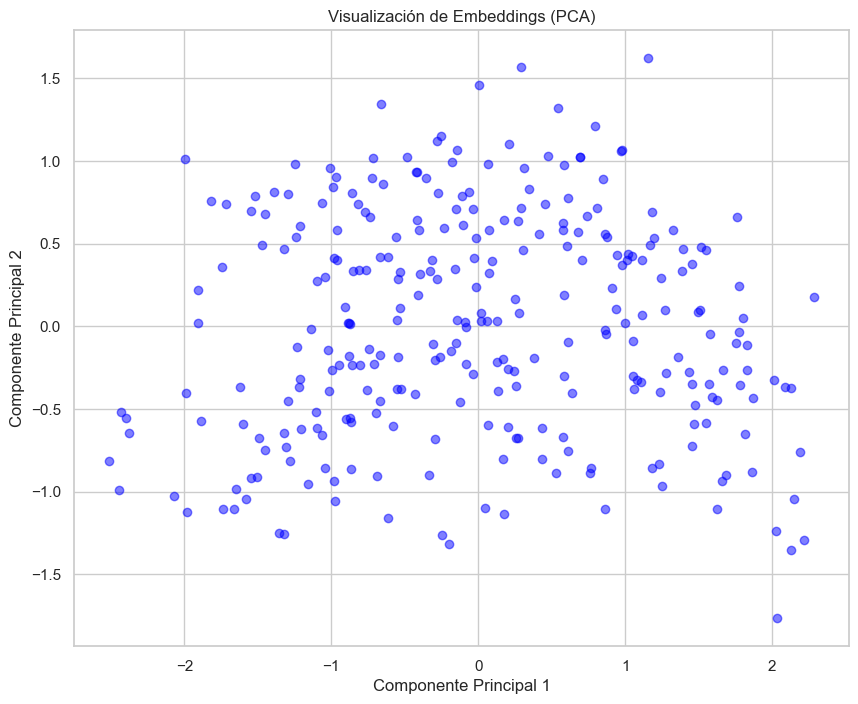

In [ ]:
# Reducir la dimensionalidad a 2D con PCA
pca = PCA(n_components=2)
embeddings_pca = pca.fit_transform(embeddings)

# Visualizar los embeddings
plt.figure(figsize=(10, 8))
plt.scatter(embeddings_pca[:, 0], embeddings_pca[:, 1], c='blue', alpha=0.5)
plt.title("Visualización de Embeddings (PCA)")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.show()

<h1> Division de DataSet </h1>

In [83]:
print("Distribución de clases en la columna 'Sentimientos':")
print(respuestas_df)

Distribución de clases en la columna 'Sentimientos':
                                               Alegría  \
0    dando clases puedo salir divertirme amigo si v...   
1                 sale bien escuela trabajo paz alegra   
2    ver recuerdos pensar escenarios imaginarios fe...   
3    paso tiempo amigo salir comer lugares felicida...   
4    hago recibo halagos hago ejercicio escucho pod...   
..                                                 ...   
283  cumplo algn objetivo meta personal felicidad c...   
284  amigo felicidad absoluta subjetiva adems encue...   
285  regularmente siento alegra logros hago cosas m...   
286                           sale bien sentirse pleno   
287  encuentro solucin algn problema talvez recorda...   

                                              Tristeza  \
0    frustrado poder hacer trabajo siento dando anc...   
1                                          salen cosas   
2    pensar cosas pasen planear cosas sucedan ver r...   
3                 

In [ ]:
# Seleccionar características (X) y etiquetas (y)
X = embeddings  # Usaremos los embeddings generados como características
y = respuestas_df  # Las etiquetas de sentimiento

In [ ]:
print(X)

[[-0.4824659  -0.18768263  0.05221269 ... -0.10314457  0.5517332
   0.40666553]
 [-0.23393069  0.02839846 -0.01978544 ... -0.22262326  0.4360636
   0.3197418 ]
 [-0.39652637 -0.20464458  0.02350665 ... -0.03318929  0.5971456
   0.51143575]
 ...
 [-0.41177884 -0.03621775  0.00431661 ... -0.08919752  0.55155843
   0.421068  ]
 [-0.32184297 -0.11314264  0.03494686 ... -0.0539816   0.27692327
   0.33847645]
 [-0.38083488 -0.05875032 -0.1250734  ... -0.23001772  0.5521608
   0.4543605 ]]


In [41]:
print(y)

                                               Alegría  \
0    dando clases puedo salir divertirme amigo si v...   
1                 sale bien escuela trabajo paz alegra   
2    ver recuerdos pensar escenarios imaginarios fe...   
3    paso tiempo amigo salir comer lugares felicida...   
4    hago recibo halagos hago ejercicio escucho pod...   
..                                                 ...   
283  cumplo algn objetivo meta personal felicidad c...   
284  amigo felicidad absoluta subjetiva adems encue...   
285  regularmente siento alegra logros hago cosas m...   
286                           sale bien sentirse pleno   
287  encuentro solucin algn problema talvez recorda...   

                                              Tristeza  \
0    frustrado poder hacer trabajo siento dando anc...   
1                                          salen cosas   
2    pensar cosas pasen planear cosas sucedan ver r...   
3                                   cosas salen quiero   
4            

In [ ]:
# Combinar las etiquetas en una sola columna con la clase principal
y_combined = y.idxmax(axis=1)  # Encuentra la columna con el valor máximo como etiqueta

# Verificar la nueva distribución de clases
print("Distribución de clases:")
print(y_combined.value_counts())

Distribución de clases:
Tristeza                  60
Enojo                     51
Miedo                     47
Inquietud/Preocupación    46
Estrés                    45
Alegría                   38
Name: count, dtype: int64


In [81]:
# Dividir el conjunto de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y_combined, test_size=0.2, random_state=42, stratify=y_combined
)

# Verificar la distribución en los conjuntos
print("Distribución en conjunto de entrenamiento:")
print(y_train.value_counts())
print("\nDistribución en conjunto de prueba:")
print(y_test.value_counts())

Distribución en conjunto de entrenamiento:
Tristeza                  48
Enojo                     41
Miedo                     37
Inquietud/Preocupación    37
Estrés                    36
Alegría                   30
Name: count, dtype: int64

Distribución en conjunto de prueba:
Tristeza                  12
Miedo                     10
Enojo                     10
Inquietud/Preocupación     9
Estrés                     9
Alegría                    8
Name: count, dtype: int64


<h1>Modelos</h1>

In [ ]:
from sklearn.model_selection import GridSearchCV, cross_val_score

from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

param_grid = {
    'n_neighbors': [3, 5, 7, 10],      # Probar diferentes números de vecinos
    'weights': ['uniform', 'distance'],  # Probar pesos iguales o basados en distancia
    'metric': ['euclidean', 'manhattan', 'cosine']  # Explorar diferentes métricas
}

# Crear el clasificador KNN
knn = KNeighborsClassifier()

# Realizar búsqueda en la cuadrícula de hiperparámetros
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy', n_jobs=-1)


In [80]:
# Modelo KNN 
from sklearn.tree import export_text


knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
print("KNN")
print("Accuracy:", accuracy_score(y_test, y_pred_knn))
print("Classification Report:\n", classification_report(y_test, y_pred_knn))

id3 = DecisionTreeClassifier(criterion='entropy', random_state=42)
id3.fit(X_train, y_train)
y_pred_id3 = id3.predict(X_test)
print("\nID3")
print("Accuracy:", accuracy_score(y_test, y_pred_id3))
print("Classification Report:\n", classification_report(y_test, y_pred_id3))
#print("Tree Structure:\n", export_text(id3, feature_names=list(X.columns)))

c45 = DecisionTreeClassifier(criterion='gini', random_state=42)
c45.fit(X_train, y_train)
y_pred_c45 = c45.predict(X_test)
print("\nC4.5")
print("Accuracy:", accuracy_score(y_test, y_pred_c45))
print("Classification Report:\n", classification_report(y_test, y_pred_c45))
#print("Tree Structure:\n", export_text(c45, feature_names=list(X.columns)))

KNN
Accuracy: 0.27586206896551724
Classification Report:
                         precision    recall  f1-score   support

               Alegría       0.19      0.38      0.25         8
                 Enojo       0.18      0.20      0.19        10
                Estrés       0.33      0.22      0.27         9
Inquietud/Preocupación       0.36      0.56      0.43         9
                 Miedo       0.38      0.30      0.33        10
              Tristeza       0.33      0.08      0.13        12

              accuracy                           0.28        58
             macro avg       0.29      0.29      0.27        58
          weighted avg       0.30      0.28      0.26        58


ID3
Accuracy: 0.1896551724137931
Classification Report:
                         precision    recall  f1-score   support

               Alegría       0.00      0.00      0.00         8
                 Enojo       0.18      0.20      0.19        10
                Estrés       0.15      0.22     

In [ ]:
# Probar SVM con kernel lineal
svm_linear = SVC(kernel="linear", C=1, random_state=42)
svm_linear.fit(X_train, y_train)

# Predicciones en el conjunto de prueba
y_pred_svm_linear = svm_linear.predict(X_test)

# Evaluar el rendimiento
print("\n--- Resultados para SVM (Kernel Lineal) ---")
print("Matriz de Confusión:")
print(confusion_matrix(y_test, y_pred_svm_linear))
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred_svm_linear))
print(f"Precisión: {accuracy_score(y_test, y_pred_svm_linear):.2f}")

# Probar SVM con kernel RBF
svm_rbf = SVC(kernel="rbf", C=1, gamma=0.1, random_state=42)
svm_rbf.fit(X_train, y_train)

# Predicciones en el conjunto de prueba
y_pred_svm_rbf = svm_rbf.predict(X_test)

# Evaluar el rendimiento
print("\n--- Resultados para SVM (Kernel RBF) ---")
print("Matriz de Confusión:")
print(confusion_matrix(y_test, y_pred_svm_rbf))
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred_svm_rbf))
print(f"Precisión: {accuracy_score(y_test, y_pred_svm_rbf):.2f}")


--- Resultados para SVM (Kernel Lineal) ---
Matriz de Confusión:
[[3 1 1 0 1 2]
 [0 3 2 2 1 2]
 [0 1 0 1 2 5]
 [0 2 4 1 1 1]
 [1 1 1 0 3 4]
 [2 2 2 2 1 3]]

Reporte de Clasificación:
                        precision    recall  f1-score   support

               Alegría       0.50      0.38      0.43         8
                 Enojo       0.30      0.30      0.30        10
                Estrés       0.00      0.00      0.00         9
Inquietud/Preocupación       0.17      0.11      0.13         9
                 Miedo       0.33      0.30      0.32        10
              Tristeza       0.18      0.25      0.21        12

              accuracy                           0.22        58
             macro avg       0.25      0.22      0.23        58
          weighted avg       0.24      0.22      0.23        58

Precisión: 0.22

--- Resultados para SVM (Kernel RBF) ---
Matriz de Confusión:
[[ 0  3  0  0  0  5]
 [ 0  3  0  0  0  7]
 [ 0  0  0  0  0  9]
 [ 0  2  0  0  0  7]
 [ 0  1  0

d:\Principal\Respaldo Diws 2020\Buap\Octavo Semestre\Mineria\proyecto final\codigos\env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Principal\Respaldo Diws 2020\Buap\Octavo Semestre\Mineria\proyecto final\codigos\env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Principal\Respaldo Diws 2020\Buap\Octavo Semestre\Mineria\proyecto final\codigos\env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no